# pySPaRTAN:a Python computational framework for linking cell-surface receptors to transcriptional regulators

## Introduction

<img src="SPaRTAN_diagram.png" alt="Diagram" width="800" />

There are three inputs for the package: D, P Y

D: gene-tf matrix. It is included in pySPaRTAN package.

P: cell x protein matrix. given by user

Y: gene x cell matrix, given by user

P and Y are generated from CITE-seq data through quality control and filtering.

## Environment setup

Please follow the section Managing Packages in repository README file

## pySPaRTAN pipeline

### 1. Importing and Preprocessing CITE_seq Data

In [25]:
import scanpy as sc
import muon as mu
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pySPaRTAN

#### Improting data

In [3]:
adata=sc.read_10x_h5("../data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
adata.var_names_make_unique()

/Users/xim33/Anaconda/anaconda3/envs/seminar2024/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata

AnnData object with n_obs × n_vars = 5527 × 33570
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [8]:
adata.var['feature_types']

MIR1302-2HG                 Gene Expression
FAM138A                     Gene Expression
OR4F5                       Gene Expression
AL627309.1                  Gene Expression
AL627309.3                  Gene Expression
                                 ...       
HLA-DR_TotalSeqB           Antibody Capture
TIGIT_TotalSeqB            Antibody Capture
IgG1_control_TotalSeqB     Antibody Capture
IgG2a_control_TotalSeqB    Antibody Capture
IgG2b_control_TotalSeqB    Antibody Capture
Name: feature_types, Length: 33570, dtype: object

#### Extracting protein and gene expression

In [4]:
# extract the protein
protein=adata[:,adata.var["feature_types"]=="Antibody Capture"].copy()

In [9]:
# remove the isotype control for antibody
protein=protein[:,[x for x in protein.var_names if "control" not in x]]

In [10]:
# save it to obsm
protein.layers['raw_counts'] = protein.X.copy()
adata.obsm["protein_raw_counts"]=protein.to_df()

In [11]:
# extract gene expression
adata = adata[:, adata.var["feature_types"] == "Gene Expression"]

In [12]:
adata.layers["raw_counts"] = adata.X.copy()

/var/folders/p7/l3vgwn3s1vl6wg6p16kkq0l00000gr/T/ipykernel_19777/2164063776.py:1: ImplicitModificationWarning: Setting element `.layers['raw_counts']` of view, initializing view as actual.
  adata.layers["raw_counts"] = adata.X.copy()


In [18]:
# Performing quality control
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False,inplace=True)

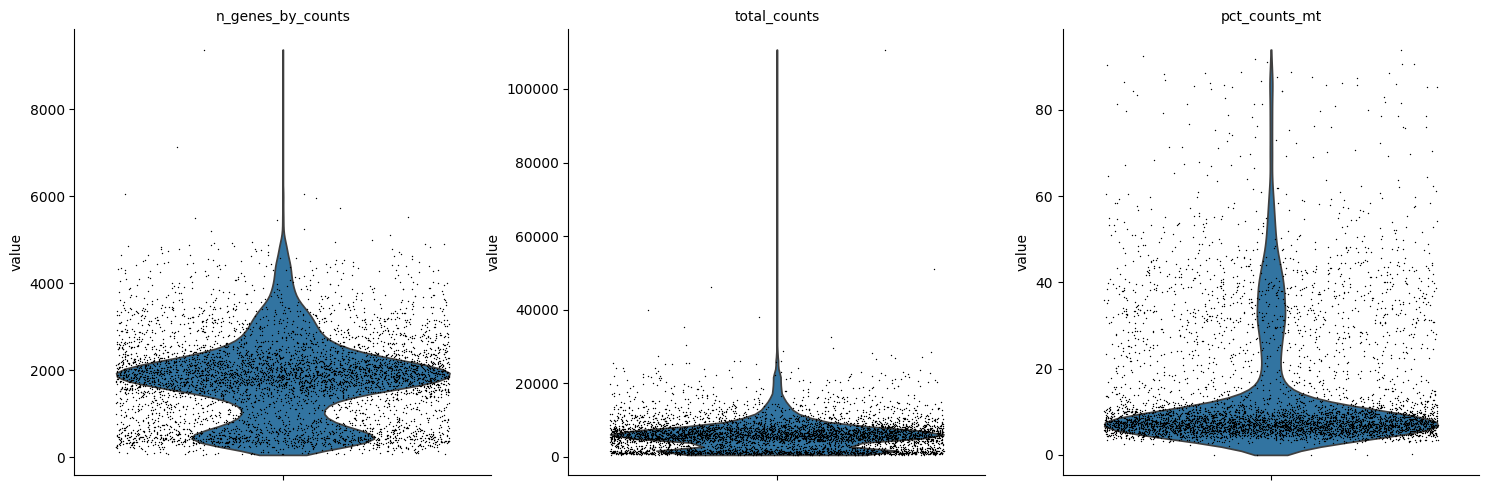

In [19]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [21]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=1000)
adata=adata[adata.obs.query("n_genes_by_counts < 5000 and pct_counts_mt<30").index]

In [22]:
# we also remove all mitoconondrial genes from the datset
adata=adata[:, adata.var['mt']==False]

In [26]:
# normalizing data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
from muon import prot as pt
pt.pp.clr(adata.obsm["protein"])
sc.pp.log1p(adata.obsm["protein"])



KeyError: 'protein'